In [1]:
import psycopg2 as pg 
import pandas as pd
import numpy as np
import random
import math

## German List Section


In [22]:
url = 'https://de.wikipedia.org/wiki/Liste_der_L%C3%A4nder_und_Territorien_nach_Einwohnerzahl'
html = pd.read_html(url)
df = max(html, key=len)
# nur staat und einwohnerzahl
df = df[['Staat', 'Einwohnerzahl (2024)']]
# welt und eu rausnehemn 
df = df[df['Staat'] != 'Welt']
df = df[df['Staat'] != 'Europäische Union']
# columns umbenenen
df.columns = ['country', 'population']
# tausender seperatoren removen
df['population'] = df['population'].str.replace('.', '') 
df['population'] = df['population'].astype(int)
# durch tausend teilen wegen einfachheit
#df['population'] = np.where(df['population'] < 1000,
#                            df['population'],
#                           df['population'].astype(int) // 1000)'
df['population'] = df['population'].apply(lambda x: math.ceil(x/1000))
# clean up country names 
df['country'] = df['country'].str.replace('\[.*?\]', '')
df['country'] = df['country'].str.strip()
df['country'] = (df['country']
                .str.replace('\[.*?\]', '', regex=True)      
                .str.replace('\xa0', ' ', regex=True)        
                .str.replace('\s+', ' ', regex=True)         
                .str.strip()) 
# reset index
df = df.reset_index(drop=True)

## Taking a look at the german list

In [31]:

daten = df
daten = daten.sort_values('population', ascending=True)
print(daten)

                 country  population
236         Vatikanstadt           1
235                 Niue           2
234              Tokelau           3
233       Falklandinseln           4
232           Montserrat           5
..                   ...         ...
4               Pakistan      251270
3             Indonesien      283488
2     Vereinigte Staaten      345427
1    Volksrepublik China     1419322
0                 Indien     1450936

[237 rows x 2 columns]


# English list section


In [73]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
html = pd.read_html(url)
df = max(html, key=len)
df = df[['Location', 'Population']]
df = df[df['Location'] != 'World']
df = df.iloc[:-2]
df.columns = ['country', 'population']
df['population'] = df['population'].astype(int)
df['population'] = df['population'].apply(lambda x: math.ceil(x/1000))
#df = df.sort_values('population', ascending=True)
df = df.reset_index(drop=True)
print(df)

                          country  population
0                           China     1409670
1                           India     1404910
2                   United States      335894
3                       Indonesia      282478
4                        Pakistan      241500
..                            ...         ...
232    Norfolk Island (Australia)           3
233  Christmas Island (Australia)           2
234            Niue (New Zealand)           2
235         Tokelau (New Zealand)           2
236                  Vatican City           1

[237 rows x 2 columns]


### Print bar diagram

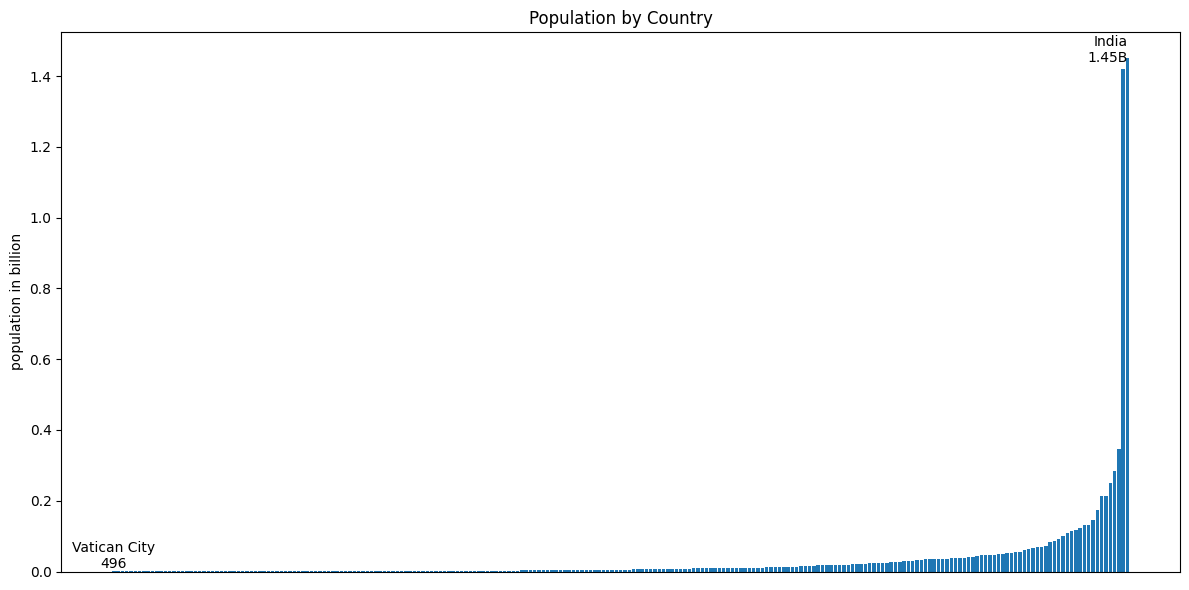

In [39]:
import matplotlib.pyplot as plt 

#assert len(countries) == len(population)
#countries = list(df['country'])
#population = list(df['population'])
countries = list(daten['country'])
population = list(daten['population'])
population = [(i/1000000) for i in population]

fig, ax = plt.subplots(figsize=(12,6))

bars = ax.bar(countries, population)

plt.xticks([])

ax.text(0,  # Position of India (first bar)
        0.001,  # Population value (slightly above the bar)
        f'Vatican City\n496', 
        ha='center', 
        va='bottom')

ax.text(len(countries)-1,  # Position of last bar
        1.43,  # Population value (slightly above the bar)
        f'India\n1.45B', 
        ha='right', 
        va='bottom')

ax.set_ylabel('population in billion')
ax.set_title('Population by Country')

plt.tight_layout()
plt.savefig('../../results/plots/population_chart.png', dpi=600, bbox_inches='tight')

plt.show()


